In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torchvision.utils as vutils
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

# download path 정의
download_root = './MNIST_DATASET'

In [3]:
# Normalize data with mean=0.5, std=1.0
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

In [4]:
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
train_dataset.data.shape, test_dataset.data.shape, train_dataset.targets.shape, test_dataset.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [5]:
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_loader = torch.utils.data.DataLoader(dataset=all_dataset, 
                         batch_size=batch_size,
                         shuffle=True, drop_last=True)
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args[0]

    def forward(self, x):
        return x.view(self.shape)

In [7]:
class Generator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(generator_in_channels, 7 * 7 * generator_in_channels),
            nn.LeakyReLU(0.2),
            Reshape((-1, generator_in_channels,7,7)),
            nn.ConvTranspose2d(generator_in_channels, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, (7,7)))
    def forward(self, noise, one_hot_labels):
        random_vector_labels = torch.cat(
            (noise, one_hot_labels), 1
        )
        generated_images = self.generator(random_vector_labels)
        return generated_images

In [9]:
class Discriminator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(discriminator_in_channels, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(128,1))
    def forward(self, images, one_hot_labels):
        image_size = images.shape[2]
        
        image_one_hot_labels = one_hot_labels[:,:,None,None]
        image_one_hot_labels = image_one_hot_labels.repeat_interleave(
            torch.tensor(image_size*image_size).to(device)
        )
        image_one_hot_labels = image_one_hot_labels.view(
            (-1, image_size, image_size, num_classes)
        )
        image_one_hot_labels = image_one_hot_labels.permute(0,3,1,2)
        images_and_labels = torch.cat((images, image_one_hot_labels), 1)
        predictions = self.discriminator(images_and_labels)
        return predictions, images_and_labels

In [10]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003)
criterion = torch.nn.BCEWithLogitsLoss().to(device)

epochs = 20

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear) :
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [13]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AdaptiveMaxPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Epoch: [0][0/1093]	generator_loss: 0.7083 (0.7083)	discriminator_loss: 0.7133 (0.7133)	
Epoch: [0][200/1093]	generator_loss: 1.0449 (1.0330)	discriminator_loss: 0.4251 (0.6693)	
Epoch: [0][400/1093]	generator_loss: 0.8730 (1.0144)	discriminator_loss: 0.5530 (0.6449)	
Epoch: [0][600/1093]	generator_loss: 0.8198 (0.9776)	discriminator_loss: 0.6028 (0.6213)	
Epoch: [0][800/1093]	generator_loss: 0.8647 (0.9534)	discriminator_loss: 0.5350 (0.6032)	
Epoch: [0][1000/1093]	generator_loss: 0.8093 (0.9332)	discriminator_loss: 0.5960 (0.5979)	


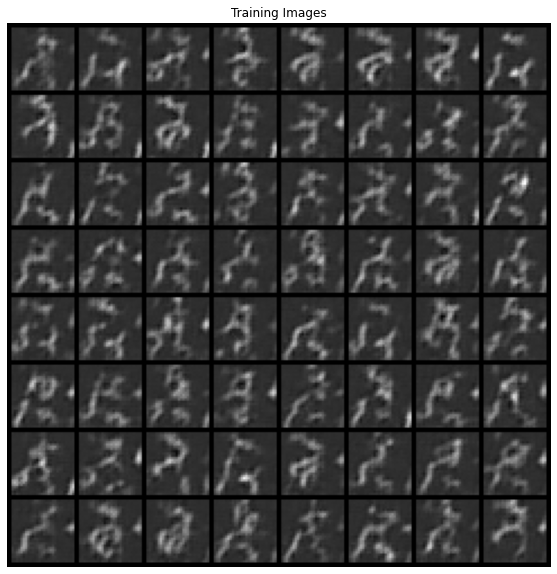

Epoch: [1][0/1093]	generator_loss: 0.8417 (0.8417)	discriminator_loss: 0.5760 (0.5760)	
Epoch: [1][200/1093]	generator_loss: 0.7960 (0.8790)	discriminator_loss: 0.6137 (0.5680)	
Epoch: [1][400/1093]	generator_loss: 0.8700 (0.8916)	discriminator_loss: 0.5903 (0.5661)	
Epoch: [1][600/1093]	generator_loss: 0.8460 (0.8927)	discriminator_loss: 0.5629 (0.5681)	
Epoch: [1][800/1093]	generator_loss: 1.0048 (0.8973)	discriminator_loss: 0.5235 (0.5664)	
Epoch: [1][1000/1093]	generator_loss: 1.0878 (0.9036)	discriminator_loss: 0.5057 (0.5644)	


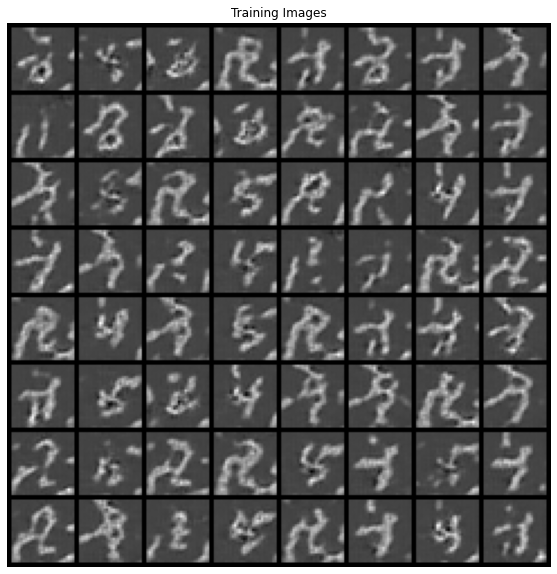

Epoch: [2][0/1093]	generator_loss: 0.9115 (0.9115)	discriminator_loss: 0.5260 (0.5260)	
Epoch: [2][200/1093]	generator_loss: 1.0265 (0.9461)	discriminator_loss: 0.5280 (0.5416)	
Epoch: [2][400/1093]	generator_loss: 0.9322 (0.9515)	discriminator_loss: 0.5538 (0.5369)	
Epoch: [2][600/1093]	generator_loss: 0.9633 (0.9541)	discriminator_loss: 0.4947 (0.5325)	
Epoch: [2][800/1093]	generator_loss: 0.8787 (0.9630)	discriminator_loss: 0.5040 (0.5262)	
Epoch: [2][1000/1093]	generator_loss: 0.8115 (0.9724)	discriminator_loss: 0.5042 (0.5200)	


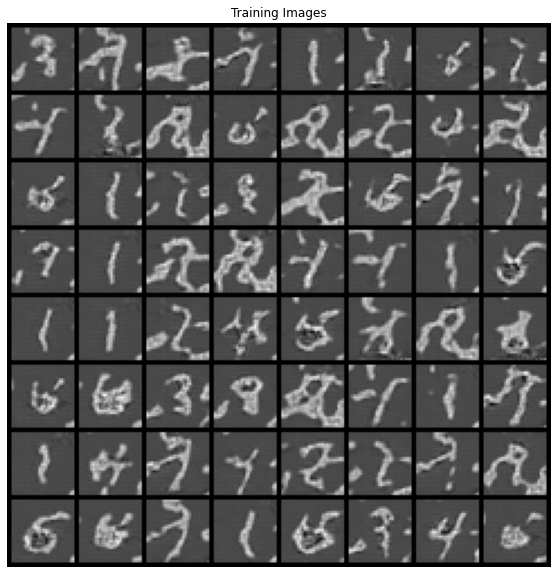

Epoch: [3][0/1093]	generator_loss: 1.1702 (1.1702)	discriminator_loss: 0.4282 (0.4282)	
Epoch: [3][200/1093]	generator_loss: 1.1021 (1.0456)	discriminator_loss: 0.4495 (0.4830)	
Epoch: [3][400/1093]	generator_loss: 1.1012 (1.0555)	discriminator_loss: 0.5063 (0.4801)	
Epoch: [3][600/1093]	generator_loss: 0.9808 (1.0750)	discriminator_loss: 0.4819 (0.4714)	
Epoch: [3][800/1093]	generator_loss: 1.1976 (1.0764)	discriminator_loss: 0.4146 (0.4724)	
Epoch: [3][1000/1093]	generator_loss: 1.2186 (1.0912)	discriminator_loss: 0.4411 (0.4659)	


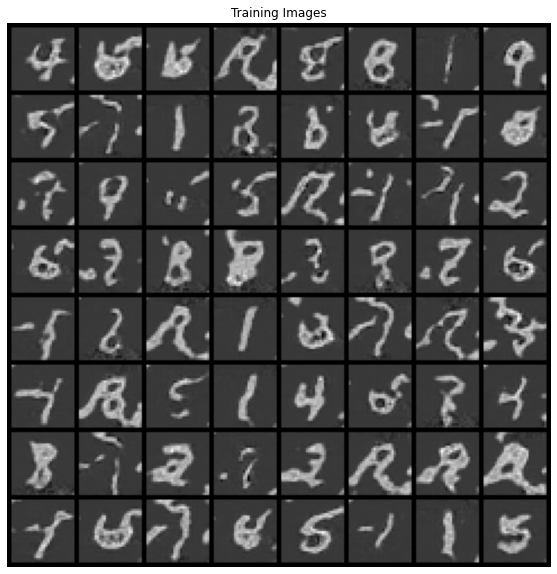

Epoch: [4][0/1093]	generator_loss: 0.9228 (0.9228)	discriminator_loss: 0.4667 (0.4667)	
Epoch: [4][200/1093]	generator_loss: 1.1795 (1.1214)	discriminator_loss: 0.4687 (0.4580)	
Epoch: [4][400/1093]	generator_loss: 1.2636 (1.1445)	discriminator_loss: 0.4233 (0.4501)	
Epoch: [4][600/1093]	generator_loss: 1.2158 (1.1515)	discriminator_loss: 0.4369 (0.4478)	
Epoch: [4][800/1093]	generator_loss: 0.9654 (1.1596)	discriminator_loss: 0.4601 (0.4444)	
Epoch: [4][1000/1093]	generator_loss: 1.4654 (1.1691)	discriminator_loss: 0.4457 (0.4413)	


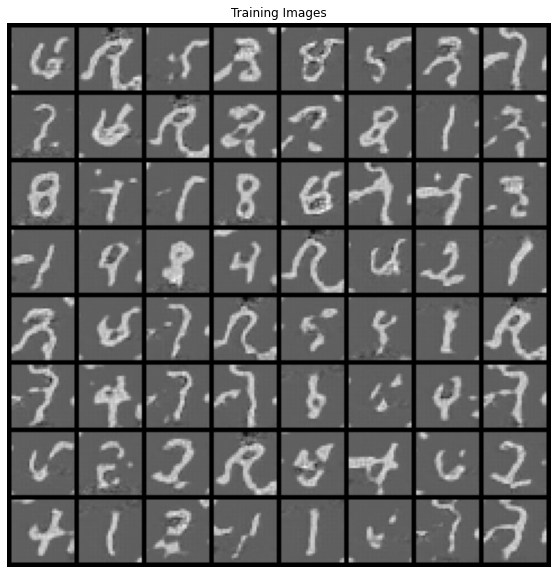

Epoch: [5][0/1093]	generator_loss: 1.0703 (1.0703)	discriminator_loss: 0.5605 (0.5605)	
Epoch: [5][200/1093]	generator_loss: 1.1295 (1.2060)	discriminator_loss: 0.3838 (0.4351)	
Epoch: [5][400/1093]	generator_loss: 1.3168 (1.2195)	discriminator_loss: 0.4530 (0.4313)	
Epoch: [5][600/1093]	generator_loss: 0.9634 (1.2235)	discriminator_loss: 0.4774 (0.4300)	
Epoch: [5][800/1093]	generator_loss: 1.1929 (1.2253)	discriminator_loss: 0.4122 (0.4292)	
Epoch: [5][1000/1093]	generator_loss: 1.2605 (1.2302)	discriminator_loss: 0.4185 (0.4274)	


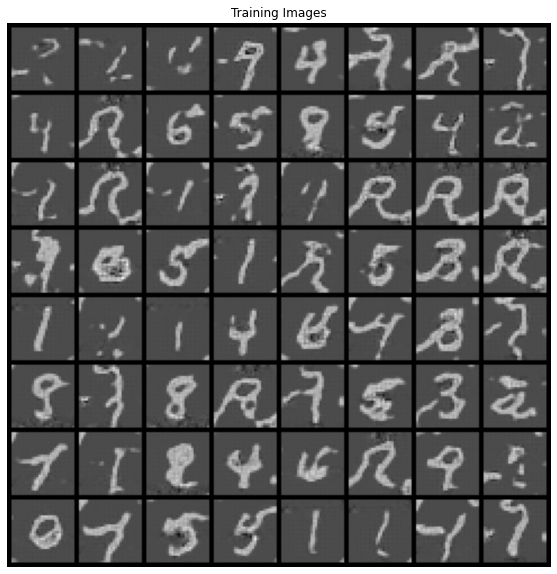

Epoch: [6][0/1093]	generator_loss: 1.1034 (1.1034)	discriminator_loss: 0.4145 (0.4145)	
Epoch: [6][200/1093]	generator_loss: 1.3817 (1.2549)	discriminator_loss: 0.3957 (0.4182)	
Epoch: [6][400/1093]	generator_loss: 1.2904 (1.2943)	discriminator_loss: 0.4288 (0.4052)	
Epoch: [6][600/1093]	generator_loss: 1.4676 (1.2896)	discriminator_loss: 0.3479 (0.4075)	
Epoch: [6][800/1093]	generator_loss: 1.1378 (1.2793)	discriminator_loss: 0.4405 (0.4110)	
Epoch: [6][1000/1093]	generator_loss: 1.2899 (1.2802)	discriminator_loss: 0.4443 (0.4117)	


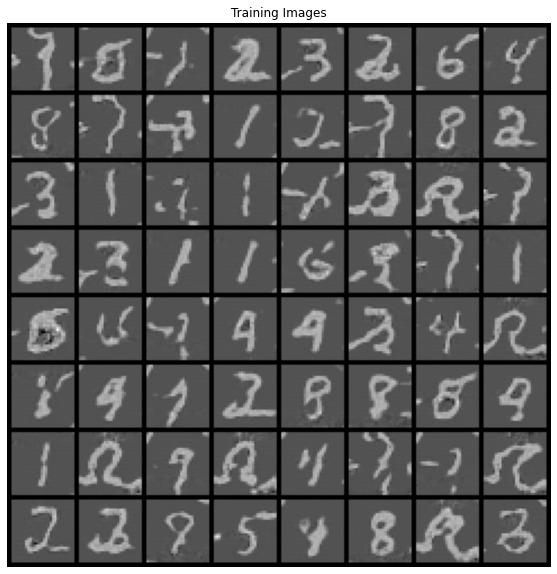

Epoch: [7][0/1093]	generator_loss: 1.1987 (1.1987)	discriminator_loss: 0.4611 (0.4611)	
Epoch: [7][200/1093]	generator_loss: 1.5144 (1.2855)	discriminator_loss: 0.4068 (0.4207)	
Epoch: [7][400/1093]	generator_loss: 1.2010 (1.3163)	discriminator_loss: 0.4447 (0.4067)	
Epoch: [7][600/1093]	generator_loss: 1.1487 (1.2922)	discriminator_loss: 0.4327 (0.4147)	
Epoch: [7][800/1093]	generator_loss: 1.2872 (1.3099)	discriminator_loss: 0.4383 (0.4083)	
Epoch: [7][1000/1093]	generator_loss: 1.3412 (1.2982)	discriminator_loss: 0.3871 (0.4118)	


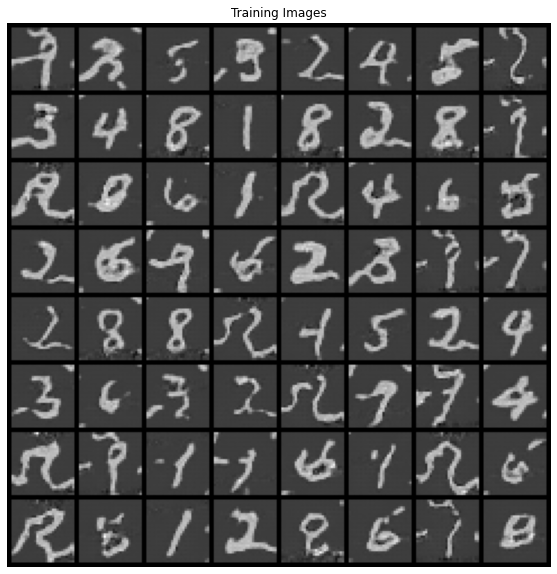

Epoch: [8][0/1093]	generator_loss: 1.2686 (1.2686)	discriminator_loss: 0.4228 (0.4228)	
Epoch: [8][200/1093]	generator_loss: 1.8083 (1.3243)	discriminator_loss: 0.4688 (0.4077)	
Epoch: [8][400/1093]	generator_loss: 1.3051 (1.2721)	discriminator_loss: 0.4517 (0.4366)	
Epoch: [8][600/1093]	generator_loss: 1.3421 (1.2762)	discriminator_loss: 0.4102 (0.4299)	
Epoch: [8][800/1093]	generator_loss: 1.2648 (1.2903)	discriminator_loss: 0.4255 (0.4222)	
Epoch: [8][1000/1093]	generator_loss: 1.2338 (1.2917)	discriminator_loss: 0.4297 (0.4211)	


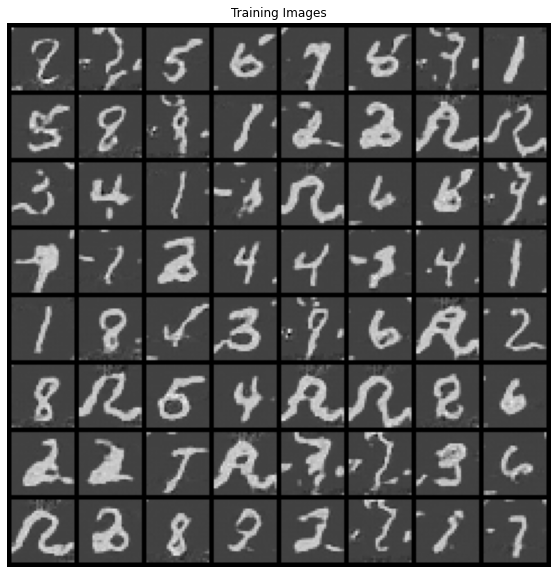

Epoch: [9][0/1093]	generator_loss: 1.4039 (1.4039)	discriminator_loss: 0.4575 (0.4575)	
Epoch: [9][200/1093]	generator_loss: 1.2771 (1.2105)	discriminator_loss: 0.4722 (0.4674)	
Epoch: [9][400/1093]	generator_loss: 0.9996 (1.2209)	discriminator_loss: 0.3953 (0.4618)	
Epoch: [9][600/1093]	generator_loss: 1.0743 (1.2418)	discriminator_loss: 0.4649 (0.4517)	
Epoch: [9][800/1093]	generator_loss: 1.2043 (1.2309)	discriminator_loss: 0.4566 (0.4568)	
Epoch: [9][1000/1093]	generator_loss: 1.8400 (1.2480)	discriminator_loss: 0.3918 (0.4505)	


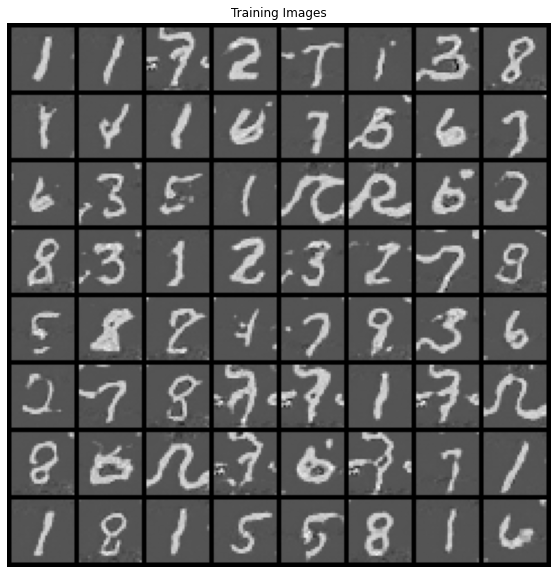

Epoch: [10][0/1093]	generator_loss: 1.2768 (1.2768)	discriminator_loss: 0.3752 (0.3752)	
Epoch: [10][200/1093]	generator_loss: 1.5301 (1.3922)	discriminator_loss: 0.3718 (0.3905)	
Epoch: [10][400/1093]	generator_loss: 1.5748 (1.3835)	discriminator_loss: 0.4057 (0.3967)	
Epoch: [10][600/1093]	generator_loss: 1.1098 (1.3245)	discriminator_loss: 0.4668 (0.4244)	
Epoch: [10][800/1093]	generator_loss: 0.9907 (1.2915)	discriminator_loss: 0.5176 (0.4431)	
Epoch: [10][1000/1093]	generator_loss: 1.4576 (1.2865)	discriminator_loss: 0.4745 (0.4424)	


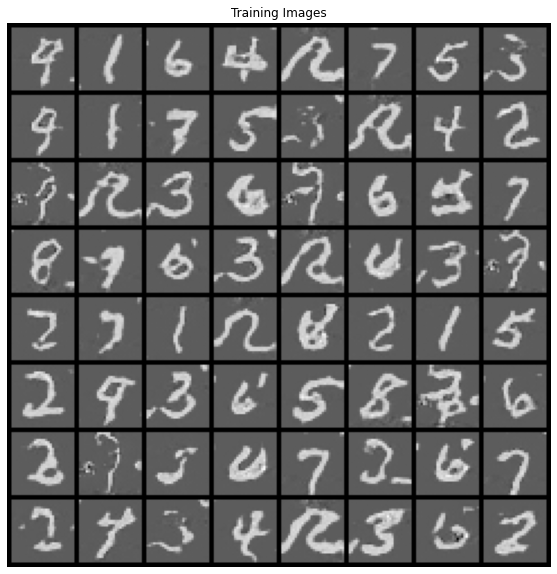

Epoch: [11][0/1093]	generator_loss: 1.1699 (1.1699)	discriminator_loss: 0.4920 (0.4920)	
Epoch: [11][200/1093]	generator_loss: 1.7747 (1.3275)	discriminator_loss: 0.3903 (0.4209)	
Epoch: [11][400/1093]	generator_loss: 1.1775 (1.2643)	discriminator_loss: 0.4768 (0.4479)	
Epoch: [11][600/1093]	generator_loss: 1.1821 (1.2283)	discriminator_loss: 0.4911 (0.4656)	
Epoch: [11][800/1093]	generator_loss: 1.1585 (1.2245)	discriminator_loss: 0.4101 (0.4653)	
Epoch: [11][1000/1093]	generator_loss: 1.4248 (1.2422)	discriminator_loss: 0.3774 (0.4583)	


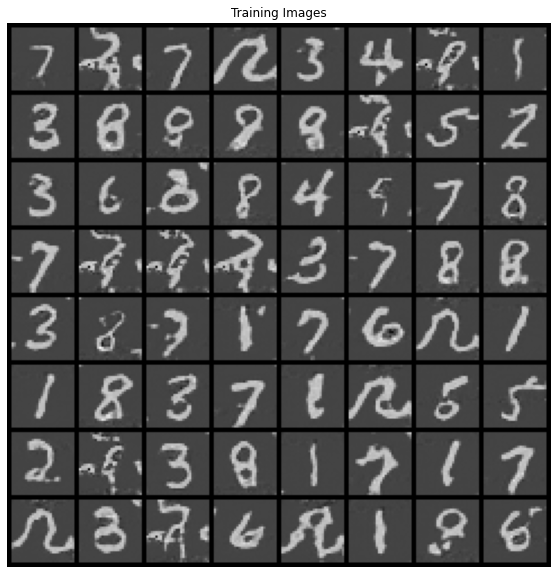

Epoch: [12][0/1093]	generator_loss: 1.3512 (1.3512)	discriminator_loss: 0.4370 (0.4370)	
Epoch: [12][200/1093]	generator_loss: 1.0767 (1.2351)	discriminator_loss: 0.5469 (0.4678)	
Epoch: [12][400/1093]	generator_loss: 1.6551 (1.2508)	discriminator_loss: 0.3526 (0.4595)	
Epoch: [12][600/1093]	generator_loss: 1.5153 (1.2641)	discriminator_loss: 0.4479 (0.4522)	
Epoch: [12][800/1093]	generator_loss: 0.8619 (1.2487)	discriminator_loss: 0.5117 (0.4580)	
Epoch: [12][1000/1093]	generator_loss: 0.9730 (1.2210)	discriminator_loss: 0.5538 (0.4715)	


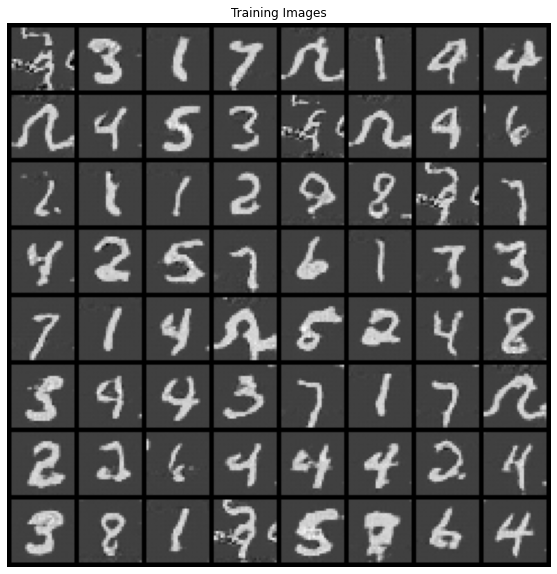

Epoch: [13][0/1093]	generator_loss: 1.0712 (1.0712)	discriminator_loss: 0.4724 (0.4724)	
Epoch: [13][200/1093]	generator_loss: 1.1865 (1.1297)	discriminator_loss: 0.5256 (0.5218)	
Epoch: [13][400/1093]	generator_loss: 1.1362 (1.1524)	discriminator_loss: 0.5046 (0.5113)	
Epoch: [13][600/1093]	generator_loss: 1.1004 (1.1918)	discriminator_loss: 0.4894 (0.4962)	
Epoch: [13][800/1093]	generator_loss: 1.0302 (1.1988)	discriminator_loss: 0.4992 (0.4905)	
Epoch: [13][1000/1093]	generator_loss: 1.1110 (1.1921)	discriminator_loss: 0.4926 (0.4918)	


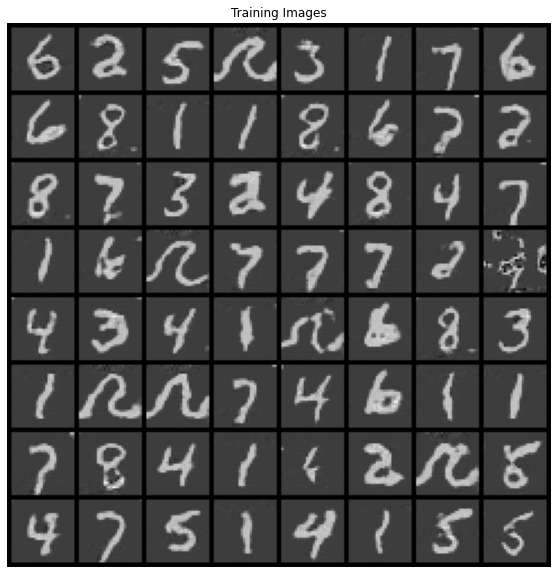

Epoch: [14][0/1093]	generator_loss: 1.3386 (1.3386)	discriminator_loss: 0.4885 (0.4885)	
Epoch: [14][200/1093]	generator_loss: 0.9143 (1.1103)	discriminator_loss: 0.5945 (0.5237)	
Epoch: [14][400/1093]	generator_loss: 0.8678 (1.1421)	discriminator_loss: 0.4889 (0.5162)	
Epoch: [14][600/1093]	generator_loss: 1.1739 (1.1848)	discriminator_loss: 0.4552 (0.4998)	
Epoch: [14][800/1093]	generator_loss: 1.4015 (1.2095)	discriminator_loss: 0.4807 (0.4872)	
Epoch: [14][1000/1093]	generator_loss: 0.9094 (1.1911)	discriminator_loss: 0.5242 (0.4960)	


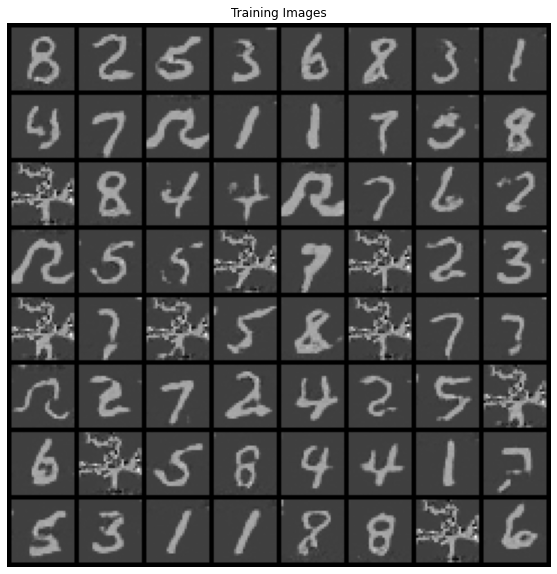

Epoch: [15][0/1093]	generator_loss: 1.1139 (1.1139)	discriminator_loss: 0.4562 (0.4562)	
Epoch: [15][200/1093]	generator_loss: 1.1594 (1.2289)	discriminator_loss: 0.5039 (0.4752)	
Epoch: [15][400/1093]	generator_loss: 1.2022 (1.1901)	discriminator_loss: 0.5636 (0.4886)	
Epoch: [15][600/1093]	generator_loss: 0.9944 (1.1943)	discriminator_loss: 0.4954 (0.4864)	
Epoch: [15][800/1093]	generator_loss: 1.3412 (1.1965)	discriminator_loss: 0.4241 (0.4863)	
Epoch: [15][1000/1093]	generator_loss: 1.0262 (1.1851)	discriminator_loss: 0.4952 (0.4918)	


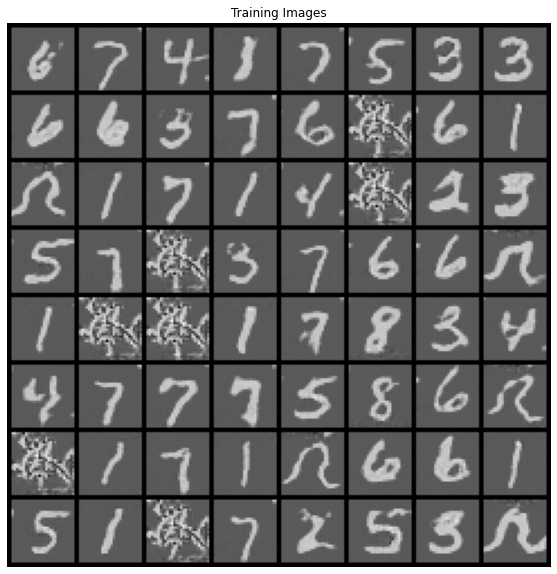

Epoch: [16][0/1093]	generator_loss: 1.4486 (1.4486)	discriminator_loss: 0.5629 (0.5629)	
Epoch: [16][200/1093]	generator_loss: 1.4990 (1.2080)	discriminator_loss: 0.4549 (0.4967)	
Epoch: [16][400/1093]	generator_loss: 1.8136 (1.1720)	discriminator_loss: 0.4745 (0.5173)	
Epoch: [16][600/1093]	generator_loss: 1.5597 (1.1865)	discriminator_loss: 0.3857 (0.5168)	
Epoch: [16][800/1093]	generator_loss: 1.4835 (1.1877)	discriminator_loss: 0.5727 (0.5172)	
Epoch: [16][1000/1093]	generator_loss: 1.1382 (1.1990)	discriminator_loss: 0.4782 (0.5144)	


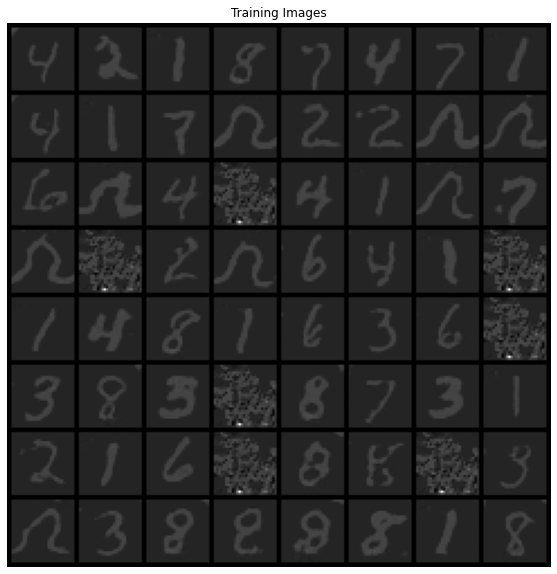

Epoch: [17][0/1093]	generator_loss: 1.2955 (1.2955)	discriminator_loss: 0.4932 (0.4932)	
Epoch: [17][200/1093]	generator_loss: 1.1496 (1.3435)	discriminator_loss: 0.5402 (0.4594)	
Epoch: [17][400/1093]	generator_loss: 1.0672 (1.2689)	discriminator_loss: 0.4636 (0.4809)	
Epoch: [17][600/1093]	generator_loss: 1.1023 (1.2069)	discriminator_loss: 0.5943 (0.5069)	
Epoch: [17][800/1093]	generator_loss: 1.2578 (1.1845)	discriminator_loss: 0.4867 (0.5129)	
Epoch: [17][1000/1093]	generator_loss: 1.2223 (1.1649)	discriminator_loss: 0.5405 (0.5222)	


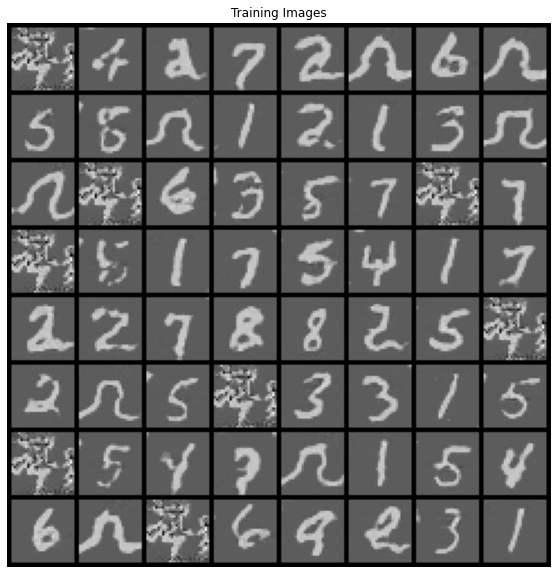

Epoch: [18][0/1093]	generator_loss: 0.8858 (0.8858)	discriminator_loss: 0.5109 (0.5109)	
Epoch: [18][200/1093]	generator_loss: 1.3620 (1.0708)	discriminator_loss: 0.4972 (0.5676)	
Epoch: [18][400/1093]	generator_loss: 0.8606 (1.0733)	discriminator_loss: 0.5993 (0.5616)	
Epoch: [18][600/1093]	generator_loss: 0.9050 (1.0741)	discriminator_loss: 0.6263 (0.5605)	
Epoch: [18][800/1093]	generator_loss: 1.1098 (1.0780)	discriminator_loss: 0.4973 (0.5580)	
Epoch: [18][1000/1093]	generator_loss: 0.9115 (1.1040)	discriminator_loss: 0.5066 (0.5464)	


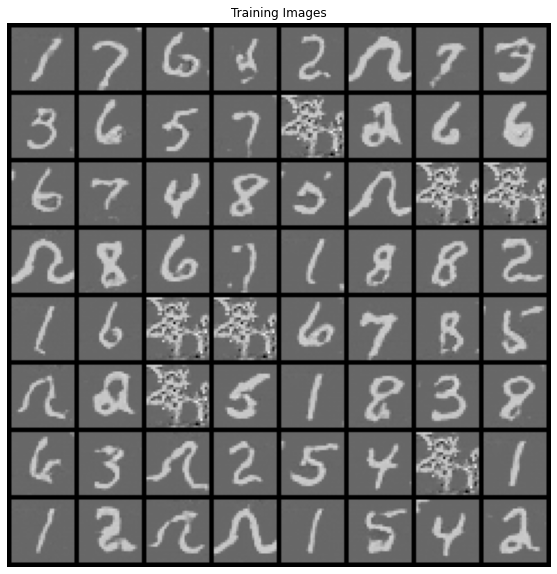

Epoch: [19][0/1093]	generator_loss: 1.1464 (1.1464)	discriminator_loss: 0.5657 (0.5657)	
Epoch: [19][200/1093]	generator_loss: 0.9734 (1.0650)	discriminator_loss: 0.5631 (0.5702)	
Epoch: [19][400/1093]	generator_loss: 1.2487 (1.0872)	discriminator_loss: 0.4193 (0.5559)	
Epoch: [19][600/1093]	generator_loss: 0.8919 (1.1148)	discriminator_loss: 0.4758 (0.5367)	
Epoch: [19][800/1093]	generator_loss: 0.8754 (1.1063)	discriminator_loss: 0.5794 (0.5370)	
Epoch: [19][1000/1093]	generator_loss: 0.7889 (1.0987)	discriminator_loss: 0.5182 (0.5397)	


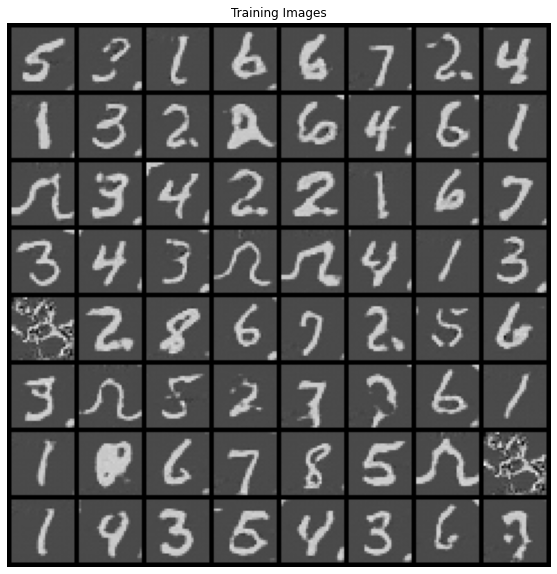

In [14]:
for epoch in range(epochs) :
    generator.train()
    discriminator.train()
    
    gen_loss_tracker = AverageMeter()
    disc_loss_tracker = AverageMeter()
    
    for i, (images, labels) in enumerate(train_loader):
        labels = F.one_hot(labels, num_classes=num_classes)
        images = images.to(device)
        labels = labels.to(device)
        
        random_latent_vectors = torch.randn(batch_size, latent_dim)
        random_latent_vectors = random_latent_vectors.to(device)
    
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake, _ = discriminator(generated_images, labels)
        predictions_real, _ = discriminator(images, labels)
        combined_predictions = torch.cat(
            (predictions_fake, predictions_real), 0
        )
        
        gt_labels = torch.cat(
            (torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), 0
        ).to(device)
        
        d_loss = criterion(combined_predictions, gt_labels)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(device)
        
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake_to_real, tmp = discriminator(generated_images, labels)
    
        misleading_labels = torch.zeros(batch_size, 1).to(device)
        
        g_loss = criterion(predictions_fake_to_real, misleading_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        disc_loss_tracker.update(np.mean(d_loss.item()))
        gen_loss_tracker.update(np.mean(g_loss.item()))
        if i % 200 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'generator_loss: {gen_loss_tracker.val:.4f} ({gen_loss_tracker.avg:.4f})\t'
                  'discriminator_loss: {disc_loss_tracker.val:.4f} ({disc_loss_tracker.avg:.4f})\t'
                  .format(epoch, i, len(train_loader),
                          gen_loss_tracker=gen_loss_tracker,
                          disc_loss_tracker=disc_loss_tracker))
            

    plt.figure(figsize=(10,10)) 
    plt.axis("off") 
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(generated_images.detach().to('cpu'), 
                                             padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

In [15]:
num_interpolation = 9
interpolation_noise = torch.randn(1, latent_dim)
interpolation_noise = torch.repeat_interleave(interpolation_noise, num_interpolation)
interpolation_noise = torch.reshape(interpolation_noise, (num_interpolation, latent_dim))
interpolation_noise = interpolation_noise.to(device)

def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = F.one_hot(torch.tensor([first_number]), num_classes)
    second_label = F.one_hot(torch.tensor([second_number]), num_classes)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = torch.linspace(0, 1, num_interpolation)[:, None]
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    ).to(device)

    fake = generator(interpolation_noise, interpolation_labels)
    return fake
start_class = 3  
end_class = 8  

fake_images = interpolate_class(start_class, end_class)

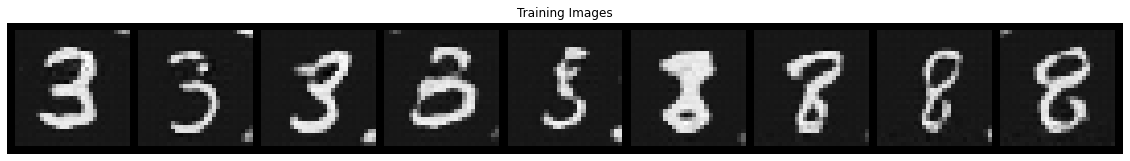

In [16]:
plt.figure(figsize=(20,20)) 
plt.axis("off") 
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.detach().to('cpu'), nrow=10,
                                         padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()